In [1]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from ganrectorch.utils import nor_phase, ffactor
from ganrectorch.ganrec import GANphase
from ganrectorch.propagators import PhaseFresnel
import torch

In [2]:
energy = 10
z = 0.4
pv = 5e-7
fname_data = './test_data/hologram_shepp.tiff'

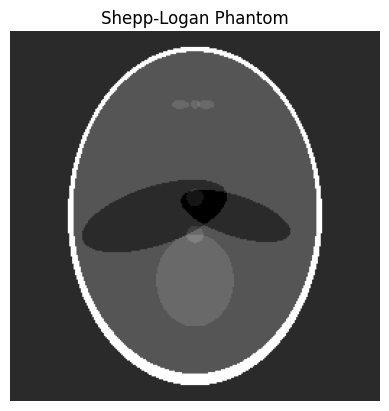

In [3]:


def generate_shepp_logan(size):
    """
    Generate a 2D Shepp-Logan phantom with pixel values restricted to (0, 1).
    
    Args:
        size (int): The size (height and width) of the output image.
        
    Returns:
        np.ndarray: A 2D array representing the Shepp-Logan phantom.
    """
    
    def ellipse(shape, v, xc, yc, a, b, angle):
        """
        Generate an ellipse mask for the Shepp-Logan phantom.
        
        Args:
            shape (tuple): The shape of the output image (height, width).
            v (float): The intensity value of the ellipse.
            xc, yc (float): The x, y center of the ellipse (normalized between -1 and 1).
            a, b (float): The half axes of the ellipse (normalized between 0 and 1).
            angle (float): The rotation angle of the ellipse in degrees.
            
        Returns:
            np.ndarray: The ellipse mask.
        """
        y, x = np.ogrid[-1:1:shape[0]*1j, -1:1:shape[1]*1j]
        
        angle = np.deg2rad(angle)
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        
        x_rot = cos_angle * (x - xc) + sin_angle * (y - yc)
        y_rot = -sin_angle * (x - xc) + cos_angle * (y - yc)
        
        ellipse_mask = ((x_rot/a)**2 + (y_rot/b)**2) <= 1
        return v * ellipse_mask.astype(np.float32)
    
    # The parameters for the 10 ellipses in the Shepp-Logan phantom
    ellipses = [
        (1, 0, 0, 0.69, 0.92, 0),         # Head
        (-0.8, 0, -0.0184, 0.6624, 0.8740, 0),  # Skull
        (-0.2, 0.22, 0, 0.11, 0.31, -72), # Top-left ellipse
        (-0.2, -0.22, 0, 0.16, 0.41, 72), # Bottom-right ellipse
        (0.1, 0, 0.35, 0.21, 0.25, 0),    # Center ellipse
        (0.1, 0, 0.1, 0.046, 0.046, 0),   # Small center ellipse
        (0.1, 0, -0.1, 0.046, 0.046, 0),  # Small bottom-center ellipse
        (0.1, -0.08, -0.605, 0.046, 0.023, 0), # Left bottom ellipse
        (0.1, 0, -0.606, 0.023, 0.023, 0),    # Bottom ellipse
        (0.1, 0.06, -0.605, 0.046, 0.023, 0)  # Right bottom ellipse
    ]
    
    phantom = np.zeros((size, size), dtype=np.float32)
    
    for v, xc, yc, a, b, angle in ellipses:
        phantom += ellipse((size, size), v, xc, yc, a, b, angle)
    
    # Normalize the phantom to the range [0, 1]
    phantom -= phantom.min()
    phantom /= phantom.max()
    
    return phantom

# Example usage
phantom = generate_shepp_logan(256)

# Visualization
plt.imshow(phantom, cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.axis('off')
plt.show()


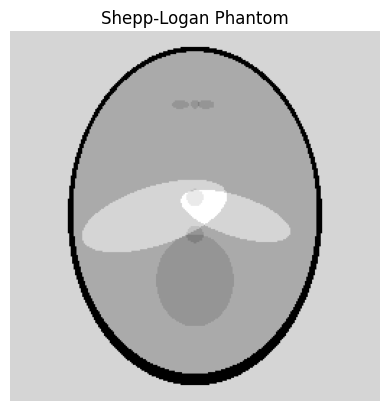

torch.Size([1, 2, 256, 256])
1.0


In [4]:
phase = np.abs(1-phantom)
plt.imshow(phase, cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.axis('off')
plt.show()
abs = phantom
recon = np.stack([phase, abs], axis=0)
recon = torch.tensor(recon)
recon = recon.unsqueeze(0)
print(recon.shape)
print(phase.max())

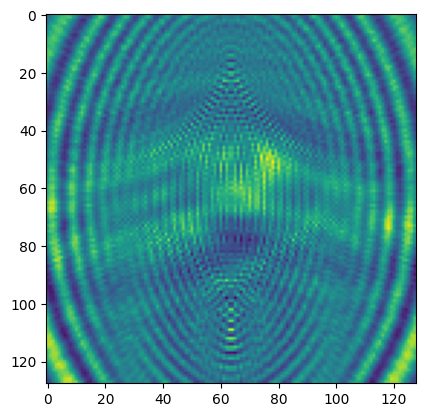

In [5]:
ff = torch.tensor(ffactor(512, energy, z, pv))
ifp = PhaseFresnel(recon, ff, 256, 0.2)(recon)

plt.imshow(ifp[0,0,:,:])
plt.show()

In [2]:
energy = 10
z = 0.5
pv = 5e-7
iter_num = 2000
fname_data = './test_data/hologram_shepp.tiff'
data = tifffile.imread(fname_data)
data = nor_phase(data)

In [3]:
abs, phase = GANphase(data, energy, z, pv, iter_num=iter_num).recon()
plt.imshow(phase)
plt.show()
tifffile.imwrite('./test_results/phase_shepp.tiff', phase)

/nsls2/users/xyang4/conda_envs/ganrec/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


AttributeError: 'PhaseFresnel' object has no attribute 'to'